<a href="https://colab.research.google.com/github/edolior/ICU-Mortality/blob/main/icu_mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installiation and relevant imports

In [ ]:
# !pip install fancyimpute
!pip install pygam
!pip install --no-cache-dir --upgrade autoimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from xgboost import XGBClassifier
from pygam import LogisticGAM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline
# from fancyimpute import *
# from sklearn.impute import *
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import calibration_curve
from sklearn import metrics
import matplotlib.lines as mlines
import matplotlib.transforms as mtransform
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import brier_score_loss
from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from autoimpute.imputations import MiceImputer
from autoimpute.analysis import MiLinearRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Connect with Google drive
This lines connects the notebook with Google Drive, in which the dataset is stored there

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

DATASET_FOLDER_NAME = 'ICU-Prediction-DB/widsdatathon2020'  #EDO
# DATASET_FOLDER_NAME = 'WiDS Datathon 2020/widsdatathon2020'  #NEVO
DRIVE_FOLDER_PATH = os.path.sep + os.path.join('content', 'drive', 'MyDrive', DATASET_FOLDER_NAME).replace('\\', '')  # the google drive folder we used
PUBLIC_DATASET = 'training_v2.csv'
publid_dataset_file_path = os.path.join(DRIVE_FOLDER_PATH, f'{PUBLIC_DATASET}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA
Exploratory data analysis

**Read the dataset CSV**

In [ ]:
df_public_dataset = pd.read_csv(publid_dataset_file_path)
# df_public_dataset = df_public_dataset[:5000] # FOR DEBGUGGIN TO REMOVE
df_public_dataset

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


## Missing values analysis

**Creates missing data list**

In [ ]:
f_missing_list = []
for curr_col in df_public_dataset.columns.tolist():
  i_null = df_public_dataset[curr_col].isnull().sum()
  i_full = df_public_dataset.shape[0]
  i_exist = i_full - i_null

  f_perc = (i_exist / i_full) * 100
  f_missing = (1 - (i_exist / i_full)) * 100

  # print('%s, Data Exists: %.2f%%, Missing: %.2f%%' % (curr_col, f_perc, f_missing))
  f_missing_list.append(f_missing)

**Density versus percentage of missing values**

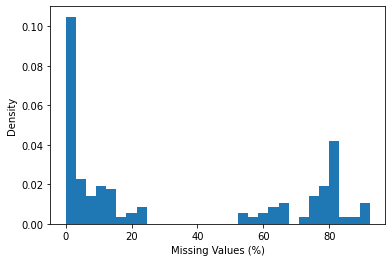

<Figure size 360x360 with 0 Axes>

In [ ]:
plt.hist(f_missing_list, density=True, bins=30);  # density=False would make counts
plt.ylabel('Density');
plt.xlabel('Missing Values (%)');
plt.figure(figsize=(5,5));

In [ ]:
print(f'Number of features {len(df_public_dataset.columns)}')

Number of features 186


**Filter variables**

In [ ]:
def filter_variables(f_threshold, df):
  df_filtered = df.copy()

  # drop features that should not be used
  l_to_remove = ['encounter_id', 'patient_id', 'readmission_status', 'apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob']
  for col_to_remove in l_to_remove:
    df_filtered.drop(col_to_remove, axis=1, inplace=True)

  # filter variables with a lot of missing values
  print(f'Number of features before filitering: {df_filtered.shape[1]}')
  for curr_col in df_filtered.columns.tolist():
    i_null = df_filtered[curr_col].isnull().sum()
    i_full = df_filtered.shape[0]
    i_exist = i_full - i_null
    f_perc = (i_exist / i_full) * 100
    if f_perc < f_threshold:
      df_filtered.drop(curr_col, axis=1, inplace=True)
      # print(f'{curr_col}, missing {100-f_perc:.2f} %')
  print(f'Number of features after filitering: {df_filtered.shape[1]}')

  return df_filtered

## Imbalanced or balanced data?

In [ ]:
s_target = 'hospital_death'
df_majority = df_public_dataset[df_public_dataset[s_target] == 0]
df_minority = df_public_dataset[df_public_dataset[s_target] == 1]
i_class0 = df_majority.shape[0]
i_class1 = df_minority.shape[0]
print(f'Count Class0:Class1, {i_class0}:{i_class1}')
print(f'Ratio Class0:Class1, {i_class0//i_class1}:{i_class1//i_class1}')

Count Class0:Class1, 83798:7915
Ratio Class0:Class1, 10:1


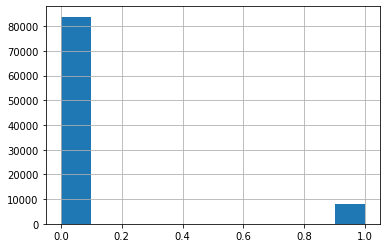

In [ ]:
df_public_dataset[s_target].hist();

# Pre-processing

**Take the target and drop from the original dataset**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
stra_cols = df_public_dataset.columns

y = df_public_dataset[s_target].copy()
X = df_public_dataset.copy()
X.drop(s_target, axis=1, inplace=True)

## Hold-out validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

In [ ]:
X_new = X_train.copy()
# X_new = X_new.iloc[:, :15]  # FOR DEBUGGING ONLY
y_new = y_train.copy()

## Handle Categorical Features

In [ ]:
def cat_to_ohe_dummies(df):
  df_ohe = df.copy()
  for curr_col in df_ohe.columns.tolist():
    if df_ohe[curr_col].dtype == object or '_id' in curr_col:
      # print(curr_col)
      one_hot_vector = pd.get_dummies(df_ohe[curr_col], prefix=curr_col, dummy_na=True)
      df_ohe.drop(curr_col, axis=1, inplace=True)
      # df_ohe = df_ohe.concat[df_ohe, one_hot_vector, axis=1]
      df_ohe = df_ohe.merge(one_hot_vector, left_index=True, right_index=True)
  return df_ohe

# Evaluation function

In [ ]:
def evaluate_model(model_obj, model_name, x_test, y_true, apache_icu_prob=None, apache_hospital_prob=None, plot=False):
  y_preds = model_obj.predict(x_test)
  if model_name == 'GAM':
    y_probs = model_obj.predict_proba(x_test)
  else:
    y_probs = model_obj.predict_proba(x_test)[:, 1]


  auc_roc = roc_auc_score(y_true, y_probs)
  precision, recall, _ = precision_recall_curve(y_true, y_probs)
  auc_pr_score = auc(recall, precision)

  if apache_icu_prob is not None:
      apache_icu_prob = [i if 0<=i<=1 else 0 if i<0 else 1 for i in apache_icu_prob]
  if apache_hospital_prob is not None:
      apache_hospital_prob = [i if 0<=i<=1 else 0 if i<0 else 1 for i in apache_hospital_prob]

  if plot:
    fig, ax = plt.subplots()
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, linewidth=1, label=f'{model_name} (AUC:{auc_roc:.2f})')
    if apache_icu_prob is not None:
      fpr, tpr, thresholds = metrics.roc_curve(y_true, apache_icu_prob)
      plt.plot(fpr, tpr, linewidth=1, label=f'apache_icu_prob (AUC:{roc_auc_score(y_true, apache_icu_prob):.2f})')
    if apache_hospital_prob is not None:
      fpr, tpr, thresholds = metrics.roc_curve(y_true, apache_hospital_prob)
      plt.plot(fpr, tpr, linewidth=1, label=f'apache_hospital_prob (AUC:{roc_auc_score(y_true, apache_hospital_prob):.2f})')
    fig.suptitle('ROC curve')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    plt.legend()
    plt.show()


    fig, ax = plt.subplots()
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_probs)
    plt.plot(precision, recall, linewidth=1, label=f'{model_name} (AUC:{auc(recall, precision):.2f})')
    if apache_icu_prob is not None:
      precision, recall, thresholds = metrics.precision_recall_curve(y_true, apache_icu_prob)
      plt.plot(precision, recall, linewidth=1, label=f'apache_icu_prob (AUC:{auc(recall, precision):.2f})')
    if apache_hospital_prob is not None:
      precision, recall, thresholds = metrics.precision_recall_curve(y_true, apache_hospital_prob)
      plt.plot(precision, recall, linewidth=1, label=f'apache_hospital_prob (AUC:{auc(recall, precision):.2f})')
    fig.suptitle('PR curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.legend()
    plt.show()


    fig, ax = plt.subplots()
    # only these two lines are calibration curves
    y_val, x_val = calibration_curve(y_true, y_probs, n_bins=10)
    clf_score = brier_score_loss(y_true, y_probs, pos_label=1)
    plt.plot(x_val, y_val, linewidth=1, label=f'{model_name} (Brier loss:{clf_score:.2f})')

    if apache_icu_prob is not None:
      y_val, x_val = calibration_curve(y_true, apache_icu_prob, n_bins=10, normalize='True')
      plt.plot(x_val, y_val, linewidth=1, label=f'apache_icu_prob (Brier loss:{ brier_score_loss(y_true, apache_icu_prob, pos_label=1):.2f})')
    if apache_hospital_prob is not None:
      y_val, x_val = calibration_curve(y_true, apache_hospital_prob, n_bins=10, normalize='True')
      plt.plot(x_val, y_val, linewidth=1, label=f'apache_hospital_prob (Brier loss:{ brier_score_loss(y_true, apache_hospital_prob, pos_label=1):.2f})')

    # reference line, legends, and axis labels
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    fig.suptitle('Calibration plot')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    plt.legend()
    plt.show()

    thresh_group = np.arange(0,1,0.01)
    net_benefit_model = calculate_net_benefit_model(thresh_group, y_probs, y_true)
    net_benefit_all = calculate_net_benefit_all(thresh_group, y_true)
    fig, ax = plt.subplots()
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = model_name)
    if apache_icu_prob is not None:
      net_benefit_apache_icu_prob = calculate_net_benefit_model(thresh_group, apache_icu_prob, y_true)
      ax.plot(thresh_group, net_benefit_apache_icu_prob, color = 'blue', label = 'apache_icu_prob')
    if apache_hospital_prob is not None:
      net_benefit_apache_hospital_prob = calculate_net_benefit_model(thresh_group, apache_hospital_prob, y_true)
      ax.plot(thresh_group, net_benefit_apache_hospital_prob, color = 'green', label = 'apache_icu_prob')
    ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
    # fig.savefig('fig1.png', dpi = 300)
    plt.show()


  return {'Fold': i_fold, 'Model': model_name, 'AUC': auc_roc, 'PR-AUC': auc_pr_score, 'Precision': precision, 'Recall': recall}

def train_test_ohe_columns_eq(X_train_fold_onehot, X_test_fold_onehot):
  col_set_train = set(X_train_fold_onehot.columns)
  col_set_test = set(X_test_fold_onehot.columns)
  cols_in_train_no_in_test = col_set_train - col_set_test  # to add to the test set with zeros?
  cols_in_test_no_in_train = col_set_test - col_set_train  # to remove from test

  # cols_in_train_no_in_test
  for col_to_add in cols_in_train_no_in_test:
    X_test_fold_onehot[col_to_add] = 0

  # cols_in_test_no_in_train
  X_test_fold_onehot.drop(list(cols_in_test_no_in_train), axis=1, inplace=True)
  X_test_fold_onehot = X_test_fold_onehot[X_train_fold_onehot.columns]

  return X_train_fold_onehot, X_test_fold_onehot

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
  net_benefit_model = np.array([])
  for thresh in thresh_group:
    y_pred_label = y_pred_score > thresh
    tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
    n = len(y_label)
    net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
    net_benefit_model = np.append(net_benefit_model, net_benefit)
  return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
  net_benefit_all = np.array([])
  tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
  total = tp + tn
  for thresh in thresh_group:
    net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
    net_benefit_all = np.append(net_benefit_all, net_benefit)
  return net_benefit_all

def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
  #Plot
  # ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
  ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
  ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')
  #Fill, Shows that the model is better than treat all and treat none The good part
  y2 = np.maximum(net_benefit_all, 0)
  y1 = np.maximum(net_benefit_model, y2)
  ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)
  #Figure Configuration, Beautify the details
  ax.set_xlim(0,0.5)
  ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
  ax.set_xlabel(
  xlabel = 'Threshold Probability',
  fontdict= {
  'family': 'Times New Roman', 'fontsize': 15}
  )
  ax.set_ylabel(
  ylabel = 'Net Benefit',
  fontdict= {
  'family': 'Times New Roman', 'fontsize': 15}
  )
  ax.grid('major')
  ax.spines['right'].set_color((0.8, 0.8, 0.8))
  ax.spines['top'].set_color((0.8, 0.8, 0.8))
  ax.legend(loc = 'upper right')
  return ax

# Impuation function

In [ ]:
def impute_bmi(df):
  df_to_impute = df.copy()
  df_to_impute['new_bmi'] = (df_to_impute['weight']*10000)/(df_to_impute['height']*df_to_impute['height'])
  df_to_impute['bmi'] = df_to_impute['bmi'].fillna(df_to_impute['new_bmi'])
  df_to_impute = df_to_impute.drop(['new_bmi'], axis = 1)

  return df_to_impute

def impute_mice(columns_to_impute, df_train, y_train, df_test):
  train = df_train.copy()
  test = df_test.copy()
  # create a multiple imputer first
  custom_imputer = MiceImputer(n=3, strategy="pmm", return_list=True)

  # pass the imputer to a linear regression model
  complex_lm = MiLinearRegression(mi=custom_imputer, model_lib="statsmodels")
  complex_lm.fit(train[columns_to_impute], y_train)
  # imputing the missing value with mice imputer
  train[columns_to_impute] = complex_lm.predict(train[columns_to_impute])
  test[columns_to_impute] = complex_lm.predict(test[columns_to_impute])
  return train, test

def impute_knn(columns_to_impute, df_train, df_test):
  train = df_train.copy()
  test = df_test.copy()
  # calling the MICE class
  imputer = KNNImputer(n_neighbors=20, weights="uniform")
  # imputing the missing value with mice imputer
  train[columns_to_impute] = imputer.fit_transform(train[columns_to_impute])
  test[columns_to_impute] = imputer.transform(test[columns_to_impute])
  return train, test

def get_cat_num_variables(df):
  cat_columns = []
  num_columns = []
  for curr_col in df.columns.tolist():
    if df[curr_col].dtype == object or '_id' in curr_col:
      cat_columns.append(cat_columns)
    else:
      num_columns.append(num_columns)
  return cat_columns, num_columns


def impute_simple(columns_to_impute, df_train, df_test):
  train = df_train.copy()
  test = df_test.copy()
  # # calling the MICE class
  # imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
  # # imputing the missing value with mice imputer
  print('simple mean imputation')
  train[columns_to_impute] = train[columns_to_impute].apply(lambda x: x.fillna(x.mean()),axis=0)
  test[columns_to_impute] = test[columns_to_impute].apply(lambda x: x.fillna(x.mean()),axis=0)
  return train, test

def impute_zero(columns_to_impute, df_train, df_test):
  train = df_train.copy()
  test = df_test.copy()
  # imputing the missing value with mice imputer
  return np.nan_to_num(train, 0), np.nan_to_num(test, 0)

def imput_complete_case(df_train, y_train):
  df_train_new = df_train.copy()
  org_columns = df_train_new.columns
  df_train_new['y_train'] = y_train
  df_train_new = df_train_new.dropna()
  return df_train_new[org_columns], df_train_new['y_train']

def feature_selection(df_train, y_train, df_test):
  # # One hot encoding
  # train_fs = cat_to_ohe_dummies(df_train)
  # test_fs = cat_to_ohe_dummies(df_test)
  # train_fs, test_fs = train_test_ohe_columns_eq(train_fs, test_fs)
  # train_fs, y_train_fs = imput_complete_case(train_fs, y_train)

  clf = ExtraTreesClassifier(n_estimators=30, max_depth=5, random_state=0)
  clf = clf.fit(df_train, y_train)
  # scaler = MinMaxScaler()
  # scaler.fit(train_fs)
  # clfs = SelectKBest(chi2, k=20)
  # clfs.fit(scaler.transform(train_fs), y_train_fs)

  model = SelectFromModel(clf, prefit=True)
  train = model.transform(df_train)
  test = model.transform(df_test)
  # print(clfs.get_feature_names_out())

  # print(f'train shape (before feature selection): {df_train.shape}')
  # print(f'train shape (after feature selection): {train.shape}')

  return train, test

In [ ]:
def pre_processing_data(X_train_fold, y_train_fold, X_test_public_fold, imputation='all'):
  # Feature filtering
  X_train_fold = filter_variables(f_threshold=80, df=X_train_fold)
  X_test_public_fold = X_test_public_fold[X_train_fold.columns]

  # Feature selection
  # X_train_fold, X_test_public_fold = feature_selection(X_train_fold, y_train_fold, X_test_public_fold, 35)

  cat_columns, num_columns = get_cat_num_variables(df=X_train_fold)
  # print('pre prcoessing fucntion')

  if imputation == 'none':  # Keeping the missing values
    # One hot encoding
    X_train_fold_onehot = cat_to_ohe_dummies(X_train_fold)
    X_test_fold_onehot = cat_to_ohe_dummies(X_test_public_fold)
    X_train_fold_onehot, X_test_fold_onehot = train_test_ohe_columns_eq(X_train_fold_onehot, X_test_fold_onehot)
    return X_train_fold_onehot, X_test_fold_onehot
  elif imputation == 'complete':
    X_train_fold = X_train_fold.loc[:, X_train_fold.isnull().mean() < 0.00001]
    # X_train_fold = X_train_fold[~pd.isnull(X_train_fold).any(axis=1)]
    X_test_public_fold = X_test_public_fold[X_train_fold.columns]

    # One hot encoding
    X_train_fold_onehot = cat_to_ohe_dummies(X_train_fold)
    X_test_fold_onehot = cat_to_ohe_dummies(X_test_public_fold)
    X_train_fold_onehot, X_test_fold_onehot = train_test_ohe_columns_eq(X_train_fold_onehot, X_test_fold_onehot)
    return X_train_fold_onehot, X_test_fold_onehot
  elif imputation == 'missing_cat':
    # One hot encoding
    X_train_fold_onehot = cat_to_ohe_dummies(X_train_fold)
    X_test_fold_onehot = cat_to_ohe_dummies(X_test_public_fold)
    X_train_fold_onehot, X_test_fold_onehot = train_test_ohe_columns_eq(X_train_fold_onehot, X_test_fold_onehot)

    X_train_fold_onehot, X_test_fold_onehot = impute_zero(columns_to_impute=num_columns,
                                                df_train=X_train_fold_onehot,
                                                df_test=X_test_fold_onehot)
    return X_train_fold_onehot, X_test_fold_onehot
  elif imputation == 'simple':
    # print('simple imputation')
    X_train_fold, X_test_public_fold = impute_simple(columns_to_impute=num_columns,
                                                    df_train=X_train_fold,
                                                    df_test=X_test_public_fold)
    # One hot encoding
    # print('One hot encoding')
    X_train_fold_onehot = cat_to_ohe_dummies(X_train_fold)
    X_test_fold_onehot = cat_to_ohe_dummies(X_test_public_fold)
    X_train_fold_onehot, X_test_fold_onehot = train_test_ohe_columns_eq(X_train_fold_onehot, X_test_fold_onehot)

    return X_train_fold_onehot, X_test_fold_onehot
  elif imputation == 'mice':
    # One hot encoding
    X_train_fold_onehot = cat_to_ohe_dummies(X_train_fold)
    X_test_fold_onehot = cat_to_ohe_dummies(X_test_public_fold)
    X_train_fold_onehot, X_test_fold_onehot = train_test_ohe_columns_eq(X_train_fold_onehot, X_test_fold_onehot)

    X_train_fold, X_test_public_fold = impute_mice(columns_to_impute=num_columns,
                                                   df_train=X_train_fold,
                                                   y_train=y_train_fold,
                                                   df_test=X_test_public_fold)

    return X_train_fold_onehot, X_test_fold_onehot
  elif imputation == 'all':
    # BMI imputation
    X_train_fold = impute_bmi(X_train_fold)
    X_test_public_fold = impute_bmi(X_test_public_fold)

    # MICE imputation
    # X_train_fold, X_test_public_fold = impute_mice(columns_to_impute=['age', 'height', 'weight', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'],
                                                  #  df_train=X_train_fold,
                                                  #  df_test=X_test_public_fold)

    # # KNN imputation
    # X_train_fold, X_test_public_fold = impute_simple(columns_to_impute=num_columns,
    #                                                 df_train=X_train_fold,
    #                                                 df_test=X_test_public_fold)

    # One hot encoding
    X_train_fold_onehot = cat_to_ohe_dummies(X_train_fold)
    X_test_fold_onehot = cat_to_ohe_dummies(X_test_public_fold)
    X_train_fold_onehot, X_test_fold_onehot = train_test_ohe_columns_eq(X_train_fold_onehot, X_test_fold_onehot)

    # Zero imputation
    X_train_fold_onehot, X_test_fold_onehot = impute_zero(columns_to_impute=num_columns,
                                                    df_train=X_train_fold_onehot,
                                                    df_test=X_test_fold_onehot)

    # Feature selection
    X_train_fold_onehot, X_test_fold_onehot = feature_selection(X_train_fold_onehot, y_train_fold, X_test_fold_onehot)

    # Standartization
    # scaler = StandardScaler()
    # X_train_fold_onehot[num_columns] = scaler.fit_transform(X_train_fold_onehot[num_columns])
    # X_test_fold_onehot[num_columns] = scaler.transform(X_test_fold_onehot[num_columns])
  else:
    print('No imputation done')
  return X_train_fold_onehot, X_test_fold_onehot

# Model comparison

In [ ]:
d_results = dict()
l_cols = ['Fold', 'Model', 'AUC', 'PR-AUC', 'Precision', 'Recall']
df_results = pd.DataFrame(columns=l_cols)

In [ ]:
cv_dict = {}
k_fold = 10
skf = StratifiedKFold(n_splits=k_fold, random_state=42, shuffle=True)

for i_fold, (i_train, i_test_public) in enumerate(skf.split(X_new, y_new)):
  print(f'FOLD: {i_fold}')
  X_train_fold, X_test_public_fold = X_new.iloc[i_train], X_new.iloc[i_test_public]
  y_train_fold, y_test_public_fold = y_new.iloc[i_train], y_new.iloc[i_test_public]
  cv_dict[i_fold] = (X_train_fold, X_test_public_fold, y_train_fold, y_test_public_fold)

FOLD: 0
FOLD: 1
FOLD: 2
FOLD: 3
FOLD: 4
FOLD: 5
FOLD: 6
FOLD: 7
FOLD: 8
FOLD: 9


In [ ]:
# for i_fold in range(k_fold):
#   print(f'FOLD: {i_fold}')
#   X_train_fold, X_test_public_fold, y_train_fold, y_test_public_fold = cv_dict[i_fold]

#   cat_columns, num_columns = get_cat_num_variables(df=X_train_fold)

#   X_train_fold_onehot, X_test_fold_onehot = pre_processing_data(X_train_fold, y_train_fold, X_test_public_fold)


#   # LogisticRegression
#   r_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=500)
#   r_model.fit(X_train_fold_onehot, y_train_fold)
#   d_results = evaluate_model(model_obj=r_model, model_name='LogisticRegression',
#                              x_test=X_test_fold_onehot, y_true=y_test_public_fold)
#   df_results = df_results.append(d_results, ignore_index=True)


#   # RandomForest
#   rf_model = RandomForestClassifier(random_state=42)
#   rf_model.fit(X_train_fold_onehot, y_train_fold)
#   d_results = evaluate_model(model_obj=rf_model, model_name='RandomForest',
#                              x_test=X_test_fold_onehot, y_true=y_test_public_fold)
#   df_results = df_results.append(d_results, ignore_index=True)


#   # GAM
#   gam_model = LogisticGAM(max_iter=500).fit(X_train_fold_onehot, y_train_fold)
#   d_results = evaluate_model(model_obj=gam_model, model_name='GAM',
#                              x_test=X_test_fold_onehot, y_true=y_test_public_fold)
#   df_results = df_results.append(d_results, ignore_index=True)


## Evaluation results

In [ ]:
set_of_classifiers = ['LogisticRegression', 'RandomForest', 'GAM']
for classifier in set_of_classifiers:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()
  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)

Classifier: LogisticRegression
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------
Classifier: RandomForest
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------
Classifier: GAM
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------


# Final evaluation

In [ ]:
d_results = dict()
l_cols = ['Fold', 'Model', 'AUC', 'PR-AUC', 'Precision', 'Recall']
df_results = pd.DataFrame(columns=l_cols)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


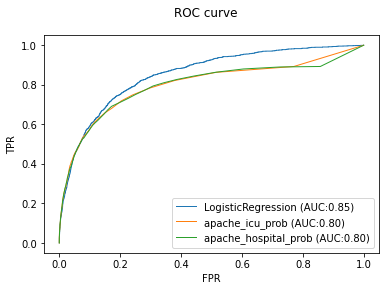

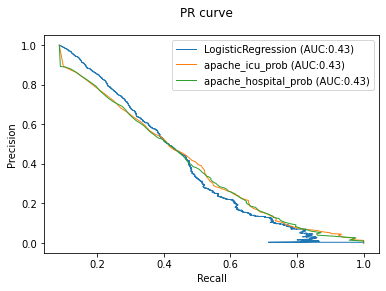

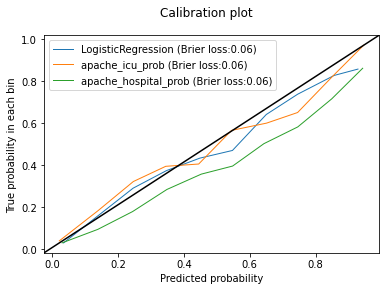

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


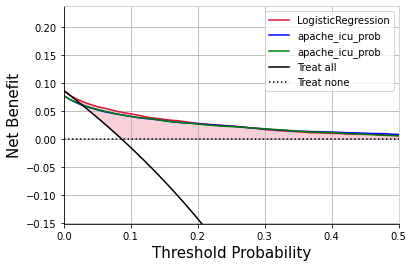

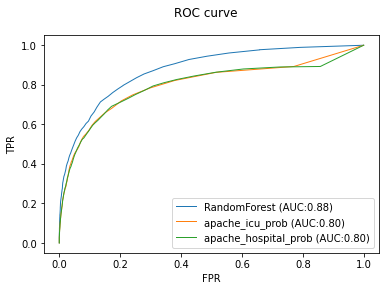

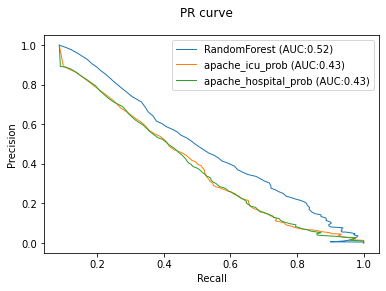

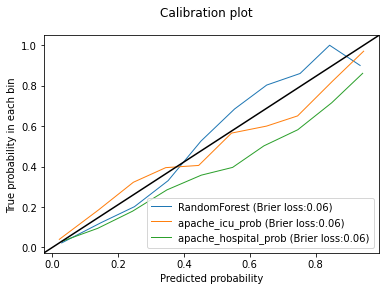

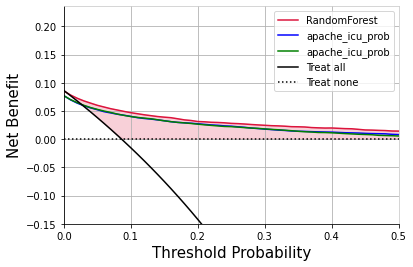

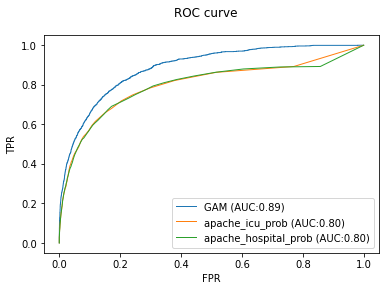

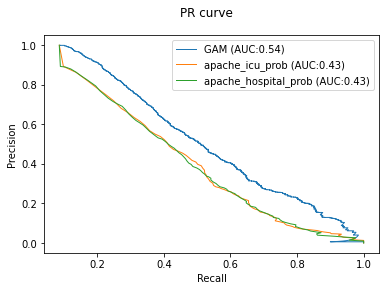

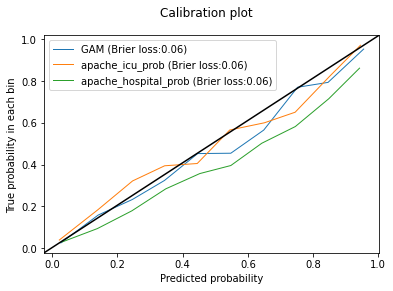

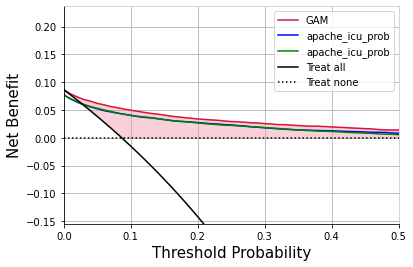

In [ ]:
# X_train, X_test, y_train, y_test
cat_columns, num_columns = get_cat_num_variables(df=X_train)

X_train_fold_onehot, X_test_fold_onehot = pre_processing_data(X_train, y_train, X_test)

apache_icu_prob = X_test['apache_4a_icu_death_prob'].fillna(0)
apache_hospital_prob = X_test['apache_4a_hospital_death_prob'].fillna(0)

# LogisticRegression
r_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=500)
r_model.fit(X_train_fold_onehot, y_train)
d_results = evaluate_model(model_obj=r_model, model_name='LogisticRegression',
                           x_test=X_test_fold_onehot, y_true=y_test,
                           apache_icu_prob=apache_icu_prob,
                           apache_hospital_prob=apache_hospital_prob,
                           plot=True)
df_results = df_results.append(d_results, ignore_index=True)


# RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_fold_onehot, y_train)
d_results = evaluate_model(model_obj=rf_model, model_name='RandomForest',
                            x_test=X_test_fold_onehot, y_true=y_test,
                           apache_icu_prob=apache_icu_prob,
                           apache_hospital_prob=apache_hospital_prob, plot=True)
df_results = df_results.append(d_results, ignore_index=True)


# GAM
gam_model = LogisticGAM(max_iter=500).fit(X_train_fold_onehot, y_train)
d_results = evaluate_model(model_obj=gam_model, model_name='GAM',
                            x_test=X_test_fold_onehot, y_true=y_test,
                           apache_icu_prob=apache_icu_prob,
                           apache_hospital_prob=apache_hospital_prob, plot=True)
df_results = df_results.append(d_results, ignore_index=True)


In [ ]:
set_of_classifiers = ['LogisticRegression', 'RandomForest', 'GAM']
for classifier in set_of_classifiers:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()

  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)


Classifier: LogisticRegression
Mean AUC-ROC: 0.8523062385700091
Mean AUPRC: 0.4282995844256441
-------------------------
Classifier: RandomForest
Mean AUC-ROC: 0.8761406621969404
Mean AUPRC: 0.5246769421070324
-------------------------
Classifier: GAM
Mean AUC-ROC: 0.8864682478059696
Mean AUPRC: 0.5351464474354186
-------------------------


# Different imputation

## Imputation: Keeping the missing values

In [ ]:
d_results = dict()
l_cols = ['Fold', 'Model', 'AUC', 'PR-AUC', 'Precision', 'Recall']
df_results = pd.DataFrame(columns=l_cols)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


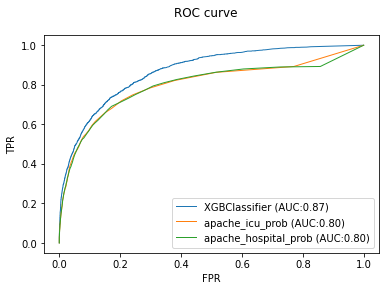

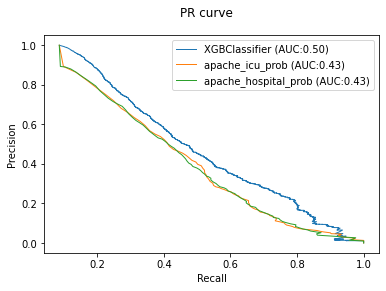

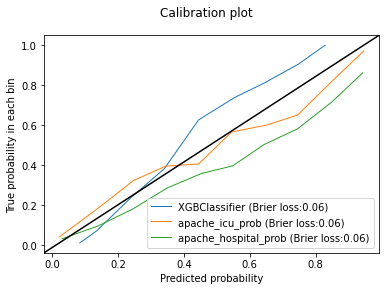

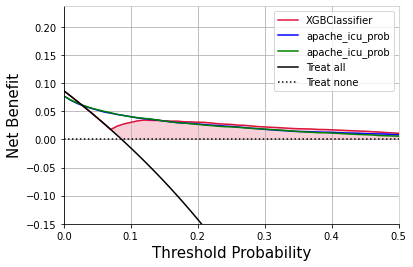

In [ ]:
#X_train, X_test, y_train, y_test
X_train_fold_onehot, X_test_fold_onehot = pre_processing_data(X_train, y_train, X_test, imputation='none')

apache_icu_prob = X_test['apache_4a_icu_death_prob'].fillna(0)
apache_hospital_prob = X_test['apache_4a_hospital_death_prob'].fillna(0)

# XGBClassifier
o_model = XGBClassifier(max_depth=4, eta=0.02, n_estimators=20, random_state=42, objective='binary:logistic')
o_model.fit(X_train_fold_onehot, y_train)
d_results = evaluate_model(model_obj=o_model, model_name='XGBClassifier',
                           apache_icu_prob=apache_icu_prob,
                           apache_hospital_prob=apache_hospital_prob,
                            x_test=X_test_fold_onehot, y_true=y_test, plot=True)
df_results = df_results.append(d_results, ignore_index=True)

In [ ]:
set_of_classifiers = ['XGBClassifier']
for classifier in set_of_classifiers:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()

  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)


Classifier: XGBClassifier
Mean AUC-ROC: 0.8690257426384451
Mean AUPRC: 0.500918104282623
-------------------------


## Imputation: Complete Case Analysis

In [ ]:
d_results = dict()
l_cols = ['Fold', 'Model', 'AUC', 'PR-AUC', 'Precision', 'Recall']
df_results = pd.DataFrame(columns=l_cols)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


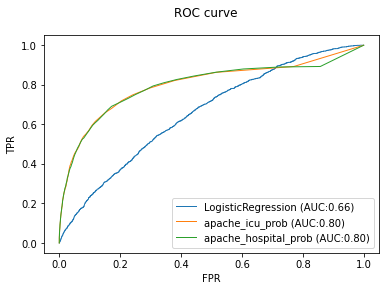

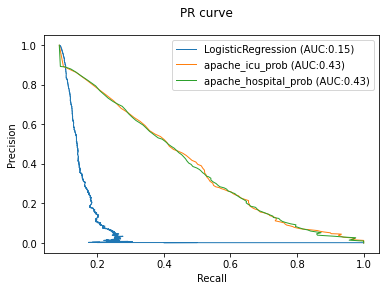

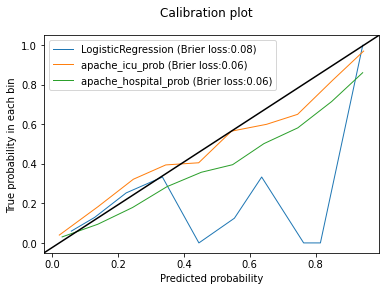

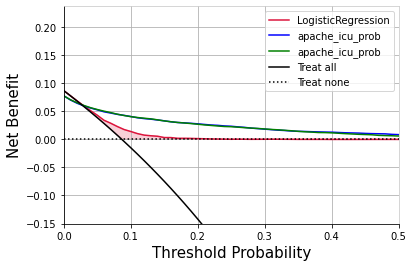

In [ ]:
#X_train, X_test, y_train, y_test
X_train_fold_onehot, X_test_fold_onehot = pre_processing_data(X_train, y_train, X_test, imputation='complete')

apache_icu_prob = X_test['apache_4a_icu_death_prob'].fillna(0)
apache_hospital_prob = X_test['apache_4a_hospital_death_prob'].fillna(0)

r_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=500)
r_model.fit(X_train_fold_onehot, y_train)
d_results = evaluate_model(model_obj=r_model, model_name='LogisticRegression',
                           x_test=X_test_fold_onehot, y_true=y_test,
                           apache_icu_prob=apache_icu_prob,
                           apache_hospital_prob=apache_hospital_prob,
                           plot=True)
df_results = df_results.append(d_results, ignore_index=True)

In [ ]:
set_of_classifiers = ['LogisticRegression']
for classifier in set_of_classifiers:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()

  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)

Classifier: LogisticRegression
Mean AUC-ROC: 0.6580744168725886
Mean AUPRC: 0.14969331680100043
-------------------------


## Imputation: A “Missing” Category

In [ ]:
d_results = dict()
l_cols = ['Fold', 'Model', 'AUC', 'PR-AUC', 'Precision', 'Recall']
df_results = pd.DataFrame(columns=l_cols)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


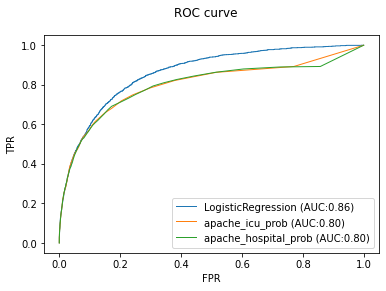

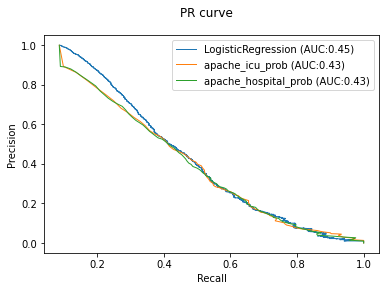

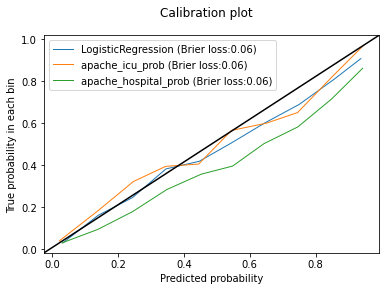

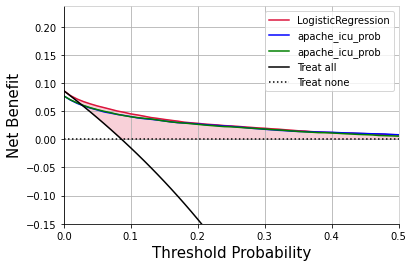

In [ ]:
#X_train, X_test, y_train, y_test
X_train_fold_onehot, X_test_fold_onehot = pre_processing_data(X_train, y_train, X_test, imputation='missing_cat')

apache_icu_prob = X_test['apache_4a_icu_death_prob'].fillna(0)
apache_hospital_prob = X_test['apache_4a_hospital_death_prob'].fillna(0)

r_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=500)
r_model.fit(X_train_fold_onehot, y_train)
d_results = evaluate_model(model_obj=r_model, model_name='LogisticRegression',
                           x_test=X_test_fold_onehot, y_true=y_test,
                           apache_icu_prob=apache_icu_prob,
                           apache_hospital_prob=apache_hospital_prob,
                           plot=True)
df_results = df_results.append(d_results, ignore_index=True)

In [ ]:
set_of_classifiers = ['LogisticRegression']
for classifier in set_of_classifiers:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()

  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)

Classifier: LogisticRegression
Mean AUC-ROC: 0.8616011108481071
Mean AUPRC: 0.45069606942600293
-------------------------


## Imputation: Simple mean

In [ ]:
d_results = dict()
l_cols = ['Fold', 'Model', 'AUC', 'PR-AUC', 'Precision', 'Recall']
df_results = pd.DataFrame(columns=l_cols)

In [ ]:
set_of_classifiers = ['LogisticRegression']
for classifier in set_of_classifiers:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()

  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)

## Imputation: Multiple Imputation by Chained Equations (MICE)


In [ ]:
d_results = dict()
l_cols = ['Fold', 'Model', 'AUC', 'PR-AUC', 'Precision', 'Recall']
df_results = pd.DataFrame(columns=l_cols)

In [ ]:
#X_train, X_test, y_train, y_test
X_train_fold_onehot, X_test_fold_onehot = pre_processing_data(X_train[:20], y_train[:20], X_test[:20], imputation='mice')

apache_icu_prob = X_test['apache_4a_icu_death_prob'].fillna(0)
apache_hospital_prob = X_test['apache_4a_hospital_death_prob'].fillna(0)

r_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=500)
r_model.fit(X_train_fold_onehot, y_train)
d_results = evaluate_model(model_obj=r_model, model_name='LogisticRegression',
                           x_test=X_test_fold_onehot, y_true=y_test,
                           apache_icu_prob=apache_icu_prob,
                           apache_hospital_prob=apache_hospital_prob,
                           plot=True)
df_results = df_results.append(d_results, ignore_index=True)

In [ ]:
set_of_classifiers = ['LogisticRegression']
for classifier in set_of_classifiers:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()

  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)

# Explainability

## Data Preparation

In [ ]:
# convert
df_X_train = X_train.copy()
df_y_train = pd.DataFrame(y_train, columns=[s_target])
nd_y_train = df_y_train.to_numpy().ravel()
df_X_test_public = X_test.copy()
df_y_test = pd.DataFrame(y_test, columns=[s_target])
nd_y_test = df_y_test.to_numpy().ravel()

# filtering
df_X_train = filter_variables(f_threshold=80, df=X_train)
df_X_test_public = df_X_test_public[df_X_test_public.columns]

# column types
cat_columns, num_columns = get_cat_num_variables(df=df_X_train)

# bmi imputation
df_X_train = impute_bmi(df_X_train)
df_X_test_public = impute_bmi(df_X_test_public)

# onehot vectors
df_X_train_onehot = cat_to_ohe_dummies(df_X_train)
df_X_test_public_onehot = cat_to_ohe_dummies(df_X_test_public)
df_X_train_onehot, df_X_test_public_onehot = train_test_ohe_columns_eq(df_X_train_onehot, df_X_test_public_onehot)

# zero imputation
df_X_train_onehot, df_X_test_public_onehot = df_X_train_onehot.replace(np.nan, 0), df_X_test_public_onehot.replace(np.nan, 0)

# feature selection
clf = ExtraTreesClassifier(n_estimators=20, max_depth=2)
clf = clf.fit(df_X_train_onehot, nd_y_train)
model = SelectFromModel(clf, prefit=True)
nd_train = model.transform(df_X_train_onehot)
i_train_features = model.get_support()
l_train_cols = df_X_train_onehot.columns[i_train_features].tolist()
df_X_train = pd.DataFrame(nd_train, columns=[l_train_cols])
nd_test = model.transform(df_X_test_public_onehot)
i_test_features = model.get_support()
l_test_cols = df_X_test_public_onehot.columns[i_test_features].tolist()
df_X_test_public = pd.DataFrame(nd_test, columns=[l_test_cols])
print(f'train shape (before feature selection): {df_X_train_onehot.shape}')
print(f'train shape (after feature selection): {df_X_train.shape}')
df_X_train.columns = [value[0] for value in df_X_train.columns.tolist()]
df_X_test_public.columns = [value[0] for value in df_X_test_public.columns.tolist()]

df_data = df_X_train.merge(df_y_train, left_index=True, right_index=True)

In [ ]:
df_X_train.columns.tolist()

## (1) Global Interpretation

### (1.1) Feature Importance

#### (1.1.1) Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

i_top = 10
m_rf = RandomForestRegressor(n_estimators=200, max_depth=4, min_samples_leaf=100, n_jobs=-1)
m_rf.fit(df_X_train, nd_y_train)
feature_importance = pd.DataFrame(columns=['Variable', 'Importance'])
feature_importance['Variable'] = df_X_train.columns
feature_importance['Importance'] = m_rf.feature_importances_
feature_importance.sort_values(by='Importance', ascending=False).head(i_top)

#### (1.1.2) Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# finds optimal alpha
x_train = df_X_train.copy()
x_train = x_train.astype('float64')
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

search = GridSearchCV(Lasso(),
                      {'alpha':np.arange(0.1, 200, 1)},
                      cv = 5, scoring='neg_mean_squared_error', verbose=0
                      )

search.fit(x_train, nd_y_train)
search.best_params_
f_alpha = search.best_params_['alpha']
f_alpha

In [ ]:
# build model
lasso_reg = Lasso(alpha=f_alpha)  # weight penalty (if too high: w->0)
lasso_reg.fit(df_X_train, nd_y_train)
lasso_pred = lasso_reg.predict(df_X_test_public)

# scores
MSE = round(mean_squared_error(lasso_pred, nd_y_test))
MAE = round(mean_absolute_error(lasso_pred, nd_y_test))
r2 = round(r2_score(lasso_pred, nd_y_test), 2)
print(f'MSE: {MSE} | MAE: {MAE} | R2score: {r2}')

# plot
coefficients = lasso_reg.coef_
importance = np.abs(coefficients)
plt.figure(figsize=(14, 6))
plt.bar(df_X_train.columns, importance)
plt.title("Feature Importance (Lasso)", fontsize=25)
plt.ylabel("t-statistic (absolute value)", fontsize=18)
plt.grid()
plt.xticks(rotation=90, fontsize=15)
plt.show()

### (1.2) Global Surrogate Model

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# (1.2) GSM by Decision Tree Regressor
y_preds_train = m_rf.predict(df_X_train) # saves preds of training set
m_dt = DecisionTreeRegressor(max_depth=4, random_state=10)  # interpretable decision tree model
m_dt.fit(df_X_train, y_preds_train)  # fitting the surrogate decision tree model using the training set and new target
decision_tree = tree.export_graphviz(m_dt, out_file='tree.dot', feature_names=df_X_train.columns, filled=True, max_depth=4)  # visualization
!dot -Tpng tree.dot -o tree.png  # converts the dot image to png format
image = plt.imread('tree.png')  # plot
plt.figure(figsize=(25,25))
plt.imshow(image)

In [ ]:
decision_tree = tree.export_graphviz(m_dt, out_file='tree.dot', feature_names=df_X_train.columns, filled=True, max_depth=2)  # visualization
!dot -Tpng tree.dot -o tree.png  # converts the dot image to png format
image = plt.imread('tree.png')  # plot
plt.figure(figsize=(25,25))
plt.imshow(image)

### (1.3) SHAP

In [ ]:
!pip install shap

In [ ]:
import shap

# (1.3) SHAP Summary/Beeswarm Plot
m_xgb = XGBClassifier(max_depth=4, eta=0.02, n_estimators=20, random_state=42, objective='binary:logistic')
m_xgb.fit(df_X_train, nd_y_train)  # on training set
shap_values = shap.TreeExplainer(m_xgb).shap_values(df_X_train)
shap.summary_plot(shap_values, df_X_train, feature_names=df_X_train.columns)

In [ ]:
# SHAP Bar Plot
shap.summary_plot(shap_values, df_X_train, plot_type="bar", feature_names=df_X_train.columns)

### (1.4) Partial Dependecy Plot

In [ ]:
!pip install pdpbox
!pip install partial-dependence

#### (1.4.1) Single Feature

In [ ]:
from pdpbox import pdp, info_plots

# (1.4) PDP - Single
s_feature = 'ventilated_apache'
# s_feature = 'age'
# s_feature = 'd1_sysbp_min'
# s_feature = 'gcs_motor_apache'
# s_feature = 'd1_spo2_min'
# s_feature = 'd1_wbc_min'

pdp_single = pdp.pdp_isolate(model=m_rf, dataset=df_X_test_public, model_features=df_X_test_public.columns, feature=s_feature)

# plot for numerical variables
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_single,
                         feature_name=s_feature+'_mean')

# plot for categorical variables
# fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_single,
#                          feature_name=s_feature+'_mean',
#                          center=True,
#                          plot_lines=True,
#                          frac_to_plot=100,
#                          plot_pts_dist=True)

plt.show()

In [ ]:
from sklearn.inspection import plot_partial_dependence

# s_feature = 'ventilated_apache'
s_feature = 'age'
# s_feature = 'd1_sysbp_min'
# s_feature = 'gcs_motor_apache'
# s_feature = 'd1_spo2_min'
# s_feature = 'd1_wbc_min'

pdp_single = plot_partial_dependence(m_rf,
                                     features=[s_feature],
                                     X=df_X_test_public,
                                     grid_resolution=10) # number of values to plot on x axis

#### (1.4.2) Feature Pair

In [ ]:
# (1.4) PDP - Pair
l_pair = ['gcs_motor_apache', 'gcs_verbal_apache']
# l_pair = ['d1_spo2_min', 'd1_sysbp_min']

inter = pdp.pdp_interact(model=m_xgb, dataset=df_X_test_public, model_features=df_X_train.columns, features=l_pair)
pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=l_pair, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()

#### (1.4.3) Weight Plot

In [ ]:
import statsmodels.api as sm

# weight plot: by linear regression coefficient values and standard errors
m_lr = sm.OLS(nd_y_train, df_X_train)  # first argument is y
results = m_lr.fit()
results.params
error = results.params - results.conf_int()[0]

coef_df = pd.DataFrame({'coefficient': results.params.values[1:], # drops the intercept
                        'error': error.values[1:],
                        'variable': error.index.values[1:]
})

# coef_df = pd.DataFrame({'coefficient': round(results.params),
#                         'standard wrror': round(results.bse),
#                         't_stats': round(results.tvalues, 1),
#                         'error': round(error)
#                        }).reset_index().rename(columns={'index': 'variable'})


# plot
coef_df.plot(y='coefficient', x='variable', kind='bar', color='none', yerr='error', legend=False, figsize=(12,8))
plt.scatter(x=np.arange(coef_df.shape[0]), s=100, y=coef_df['coefficient'], color='blue')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.title('Weight Plot: Coefficient and Standard Error')
plt.show()

## (2) Local Interpretation

### (2.1) Lime

In [ ]:
!pip install lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

m_rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=100, n_jobs=-1, random_state=10)
m_rf.fit(df_X_train, nd_y_train)

# i_record = np.random.randint(0, np.array(df_X_test_public).shape[0])
i_record = 5  # use 1 arbitrary row of data from X_test

explainer = LimeTabularExplainer(df_X_train.values, mode="regression", feature_names=df_X_train.columns)
X_observation = df_X_test_public.iloc[[i_record], :]
m_rf.predict(X_observation)[0]
explanation = explainer.explain_instance(X_observation.values[0], m_rf.predict)

explanation.show_in_notebook(show_table=True, show_all=False)
print(f'Explaination Score: {explanation.score:.2f}')

### (2.2) SHAP: By Record

In [ ]:
# (2.2) SHAP Force Plot
m_rf = RandomForestRegressor(n_estimators=200, max_depth=4, min_samples_leaf=100, n_jobs=-1)
m_rf.fit(df_X_train, nd_y_train)
explainer = shap.TreeExplainer(m_rf)
shap.initjs()
i_record = 5  # use 1 arbitrary row of data from X_test
shap_values = explainer.shap_values(df_X_test_public)
shap.force_plot(explainer.expected_value, shap_values[i_record,:], df_X_test_public.iloc[0,:], feature_names=df_X_test_public.columns)
# shap.force_plot(explainer.expected_value, shap_values[0,:100], df_X_train.iloc[0,:100])

# Bootstrap

## Emperical Cumulative Distribution Function (ECDF)

In [ ]:
def ecdf(data):
    # function computes the cumulative distribution function (ECDF) for a 1d array of samples
    n = len(data) # number of samples
    x = np.sort(data) # data for ECDF
    y = np.arange(1, n + 1) / n  # y for ECDF
    return x, y

In [ ]:
s_sample = 'age'

data = df_data[s_sample]
target = df_data[s_target]

n_size = len(df_data)  # size of data samples
n_iterations = 50  # number of bootstrap samples to create

for i_bootstrap in range(n_iterations):
    bs_sample = np.random.choice(data, size=n_size)  # sample array
    x, y = ecdf(bs_sample)  # computes ECDF plot from bootstrap sample
    _ = plt.plot(x, y, marker='.', linestyle='none', color='gray', alpha=0.1)

x, y = ecdf(data)  # ECDF plot of original data
_ = plt.plot(x, y, marker='.')

plt.margins(0.02)  # margins and label axes
_ = plt.xlabel(s_sample)
_ = plt.ylabel('ECDF')

plt.show()

## Mean and Standard Deviation

In [ ]:
def bootstrap_replicate_1d(data, func):
    # function generates bootstrap replicates for a given 1D sample array
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [ ]:
def draw_bs_reps(data, func, size=1):
    # function draws bootstrap replicates
    bs_replicates = np.empty(size)  # inits array of replicates
    for i in range(size): # generates replicates
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

In [ ]:
i_count = 10000 # number of iterations

# bootstrap replicates by mean
bs_replicates = draw_bs_reps(data, np.mean, size=i_count)

std_mean = np.std(data) / np.sqrt(len(data))  # standard error of the mean
print(f'mean: {std_mean}')

bs_std = np.std(bs_replicates)  # computes standard deviation of bootstrap replicates
print(f'standard deviation: {bs_std}')

_ = plt.hist(bs_replicates, bins=50, density=True)  # histogram
_ = plt.xlabel(s_sample)
_ = plt.ylabel('PDF')  # pobability density function

In [ ]:
# confidence interval by percentile
low_boundary = 2.5
high_boundary = 97.5
np.percentile(bs_replicates, [low_boundary, high_boundary])

In [ ]:
# bootstrap replicates by variance
bs_replicates = draw_bs_reps(data, np.var, size=i_count)
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel('Variance')
_ = plt.ylabel('PDF')

In [ ]:
# by mean of hospital death
bs_replicates = draw_bs_reps(target, np.mean, i_count)
conf_int = np.percentile(bs_replicates, [low_boundary, high_boundary])  # 95% confidence interval
print('95% confidence interval =', conf_int, 'Hospital Mortality')

_ = plt.hist(bs_replicates, bins=50, density=True)  # histogram
_ = plt.xlabel(s_target)
_ = plt.ylabel('PDF')

## Pairs

In [ ]:
def draw_bs_pairs_linreg(x, y, size=1):
    # function perform pairs bootstrap for linear regression

    inds = np.arange(len(x))  # sets array of indices to sample from
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    for i in range(size):  # generates replicates
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

In [ ]:
i = 1000
data = np.array(df_data[s_sample])
target = np.array(df_data[s_target])

bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(data, target, i)  # generates replicates of slope and intercept using pairs bootstrap
print(np.percentile(bs_slope_reps, [low_boundary, high_boundary]))
_ = plt.hist(bs_slope_reps, bins=50, density=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')

## Regression

In [ ]:
i_range = 100
x = np.array([0, i_range])  # generates array of x-values for bootstrap lines

for i in range(i_range):  # plots bootstrap lines
    _ = plt.plot(x,
                 bs_slope_reps[i] * x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')
_ = plt.plot(data, target, marker='.', linestyle='none')
_ = plt.xlabel(s_sample)
_ = plt.ylabel(s_target)
plt.margins(0.02)

# Fairness

## Unbalanced Features

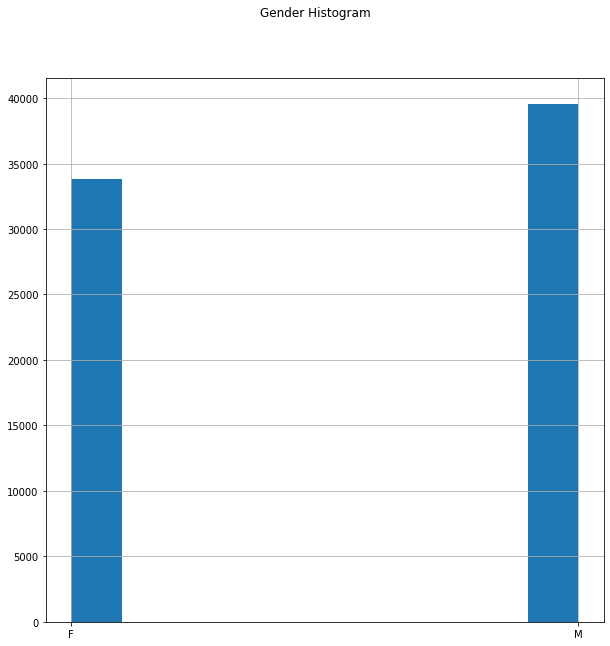

In [ ]:
fig = plt.figure(figsize = (12,10))
fig.suptitle("Gender Histogram")
X_train['gender'].hist()

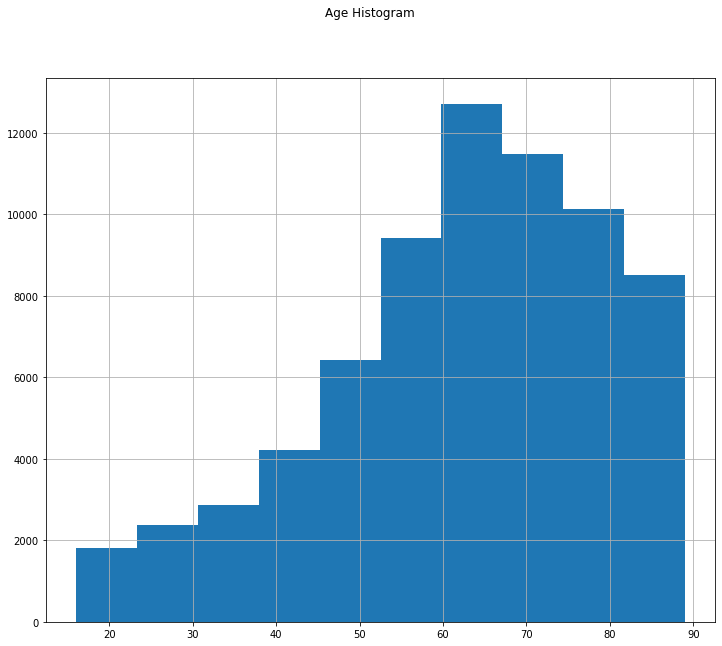

In [ ]:
fig = plt.figure(figsize = (12,10))
fig.suptitle("Age Histogram")
X_train['age'].hist()

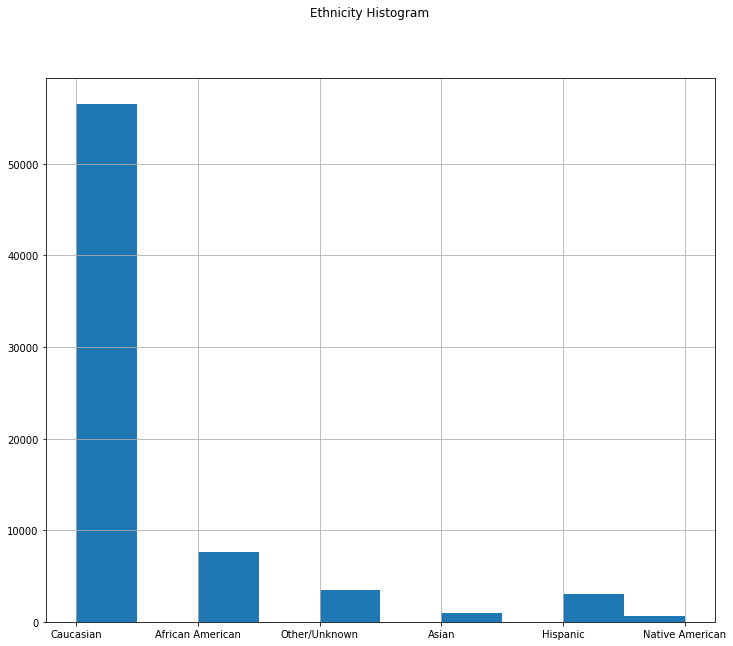

In [ ]:
fig = plt.figure(figsize = (12,10))
# ax = fig.gca()
fig.suptitle("Ethnicity Histogram")
X_train['ethnicity'].hist()

In [ ]:
test_df = X_test.join(y_test)
test_df

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
72745,123080,57411,92,52.0,32.752149,0,Other/Unknown,M,167.6,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
69839,31104,46009,13,62.0,28.514183,1,Other/Unknown,M,170.2,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
54311,130744,34822,194,70.0,27.292544,0,Caucasian,M,183.0,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
74629,126712,103832,185,52.0,46.670932,0,Caucasian,M,163.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
40192,23032,12064,62,72.0,34.792046,1,Caucasian,M,177.0,Recovery Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14060,82488,115879,174,62.0,29.475996,1,Caucasian,M,175.3,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Undefined diagnoses,0
34883,114671,66891,70,38.0,67.814990,0,African American,M,137.2,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0
76969,56022,128863,47,66.0,28.689559,0,Caucasian,M,178.0,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
26602,23466,123367,161,45.0,32.242975,0,Caucasian,M,173.0,Emergency Department,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0


In [ ]:
def plot_multiple_tests_roc_graphs(model_obj, names, xs_test, ys_true, apache_icu_prob, apache_hospital_prob):
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 30)
  # fig.figure(figsize = (20,10))
  for model_name, x_test, y_true in zip(names, xs_test, ys_true):
    # y_preds = model_obj.predict(x_test)
    try:
      y_probs = model_obj.predict_proba(x_test)[:, 1]
      auc_roc = roc_auc_score(y_true, y_probs)
      fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probs)
      plt.plot(fpr, tpr, linewidth=1, label=f'{model_name} (AUC:{auc_roc:.2f})')
    except:
      print(model_name)
      continue

  y_true = ys_true[0]
  if apache_icu_prob is not None:
      fpr, tpr, thresholds = metrics.roc_curve(y_true, apache_icu_prob)
      plt.plot(fpr, tpr, linewidth=1, label=f'apache_icu_prob (AUC:{roc_auc_score(y_true, apache_icu_prob):.2f})')
  if apache_hospital_prob is not None:
      fpr, tpr, thresholds = metrics.roc_curve(y_true, apache_hospital_prob)
      plt.plot(fpr, tpr, linewidth=1, label=f'apache_hospital_prob (AUC:{roc_auc_score(y_true, apache_hospital_prob):.2f})')

  fig.suptitle('ROC curve')
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')
  plt.legend()
  plt.show()

## Ethnicity Subgroups Evaluation

In [ ]:
ethnicities = list(test_df['ethnicity'].unique())[:-1]
ethnicities

['Other/Unknown',
 'Caucasian',
 'African American',
 'Hispanic',
 'Native American',
 'Asian']

In [ ]:
x_cols = list(test_df.columns)
x_cols.remove(s_target)

In [ ]:
apache_icu_prob = X_test['apache_4a_icu_death_prob'].fillna(0)
apache_hospital_prob = X_test['apache_4a_hospital_death_prob'].fillna(0)

xs_test, ys_test, names = [X_test_fold_onehot], [y_test], ['LogisticRegression']
for ethnicity in ethnicities:
  ethnicity_test_df = test_df.query(f'ethnicity=="{ethnicity}"')
  X_test_ethnicity, y_test_ethnicity = ethnicity_test_df[x_cols], ethnicity_test_df[s_target]
  X_train_fold_onehot, X_test_ethnicity_onehot = pre_processing_data(X_train, y_train, X_test_ethnicity)
  model_name = f'LogisticRegression-{ethnicity} Testset'

  xs_test.append(X_test_ethnicity_onehot)
  ys_test.append(y_test_ethnicity)
  names.append(model_name)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)


Test set Results for African American Ethnicity

In [ ]:
apache_icu_prob = X_test['apache_4a_icu_death_prob'].fillna(0)
apache_hospital_prob = X_test['apache_4a_hospital_death_prob'].fillna(0)

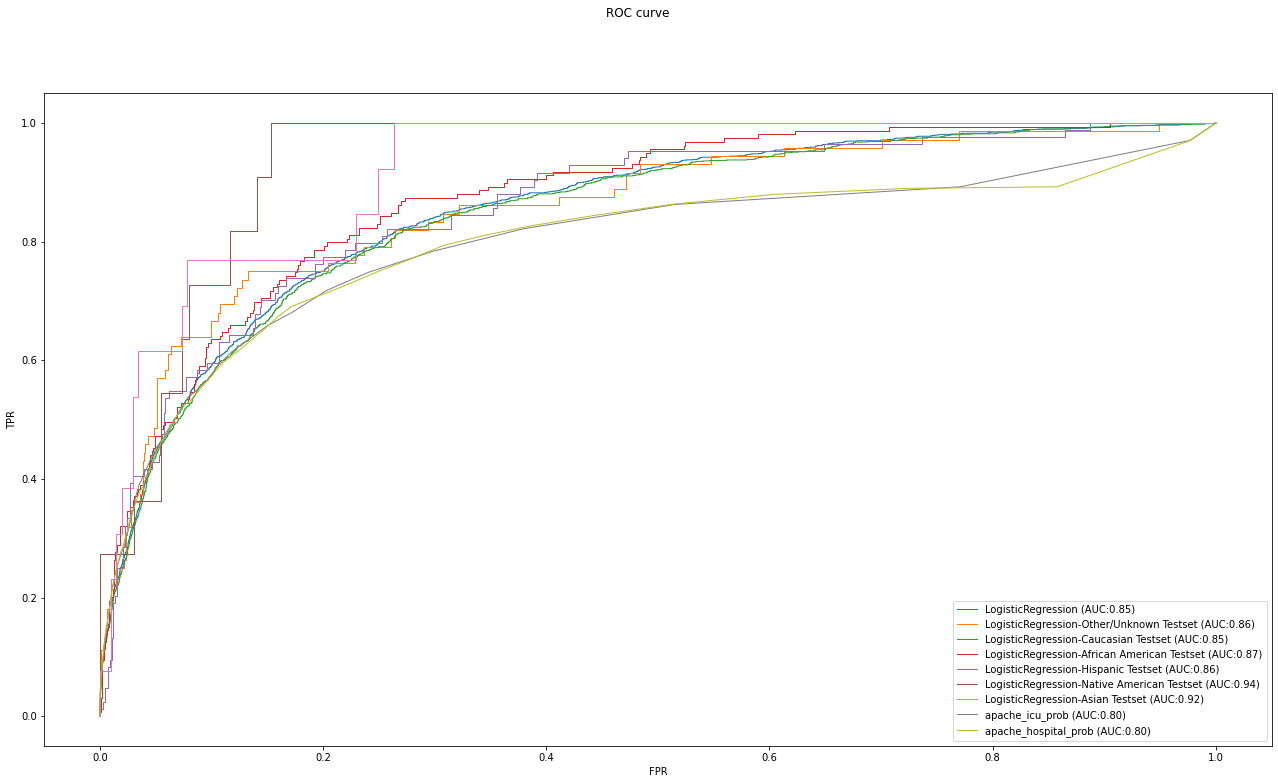

In [ ]:
plot_multiple_tests_roc_graphs(r_model, names, xs_test, ys_test, apache_icu_prob, apache_hospital_prob)

Test set Results for Caucasian Ethnicity

In [ ]:
set_of_classifiers = ['LogisticRegressionAATest', 'LogisticRegressionCauTest']
for classifier in names:
  df_result_classifier = df_results[df_results['Model']==classifier]
  mean_auc_roc = df_result_classifier['AUC'].mean()
  mean_auprc = df_result_classifier['PR-AUC'].mean()

  print(f'Classifier: {classifier}')
  print(f'Mean AUC-ROC: {mean_auc_roc}')
  print(f'Mean AUPRC: {mean_auprc}')
  print('-'*25)

Classifier: LogisticRegression
Mean AUC-ROC: 0.8523062385700091
Mean AUPRC: 0.4282995844256441
-------------------------
Classifier: LogisticRegression-Other/Unknown Testset
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------
Classifier: LogisticRegression-Caucasian Testset
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------
Classifier: LogisticRegression-African American Testset
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------
Classifier: LogisticRegression-Hispanic Testset
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------
Classifier: LogisticRegression-Native American Testset
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------
Classifier: LogisticRegression-Asian Testset
Mean AUC-ROC: nan
Mean AUPRC: nan
-------------------------


## Age Groups Evaluation
Groups:
0-30, 30-50, 50-70, 70+

In [ ]:
age_groups = [(0, 30), (30, 50), (50, 70), (70, 100)]
xs_test, ys_test, names = [X_test_fold_onehot], [y_test], ['LogisticRegression']
for age_group in age_groups:
  age_test_df = test_df.query(f'age >= {age_group[0]} & age < {age_group[1]}')
  X_test_age, y_test_age = age_test_df[x_cols], age_test_df[s_target]
  X_train_fold_onehot, X_test_age_onehot = pre_processing_data(X_train, y_train, X_test_age)
  model_name = f'LogisticRegression-Ages:{age_group} Testset'

  xs_test.append(X_test_age_onehot)
  ys_test.append(y_test_age)
  names.append(model_name)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)


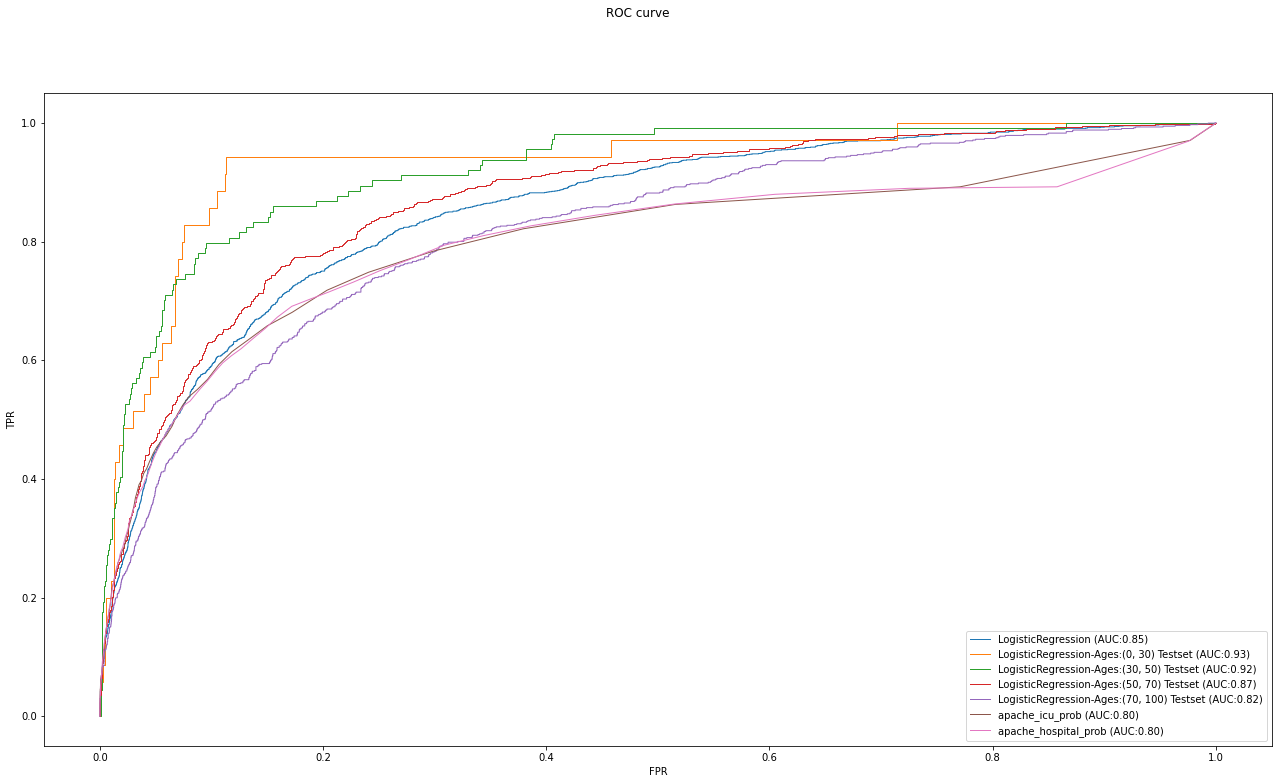

In [ ]:
plot_multiple_tests_roc_graphs(r_model, names, xs_test, ys_test, apache_icu_prob, apache_hospital_prob)

## Age Groups & Ethnicity Evaluation

In [ ]:
xs_test, ys_test, names = [X_test_fold_onehot], [y_test], ['LogisticRegression']
for ethnicity in ethnicities:
  ethnicity_test_df = test_df.query(f'ethnicity=="{ethnicity}"')
  for age_group in age_groups:
    cur_test_df = ethnicity_test_df.query(f'age >= {age_group[0]} & age < {age_group[1]}')
    X_test_cur, y_test_cur = cur_test_df[x_cols], cur_test_df[s_target]
    X_train_fold_onehot, X_test_cur_onehot = pre_processing_data(X_train, y_train, X_test_cur)
    model_name = f'LogisticRegression-Ages:{age_group} & Ethnicity:{ethnicity} Testset'

    xs_test.append(X_test_cur_onehot)
    ys_test.append(y_test_cur)
    names.append(model_name)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)


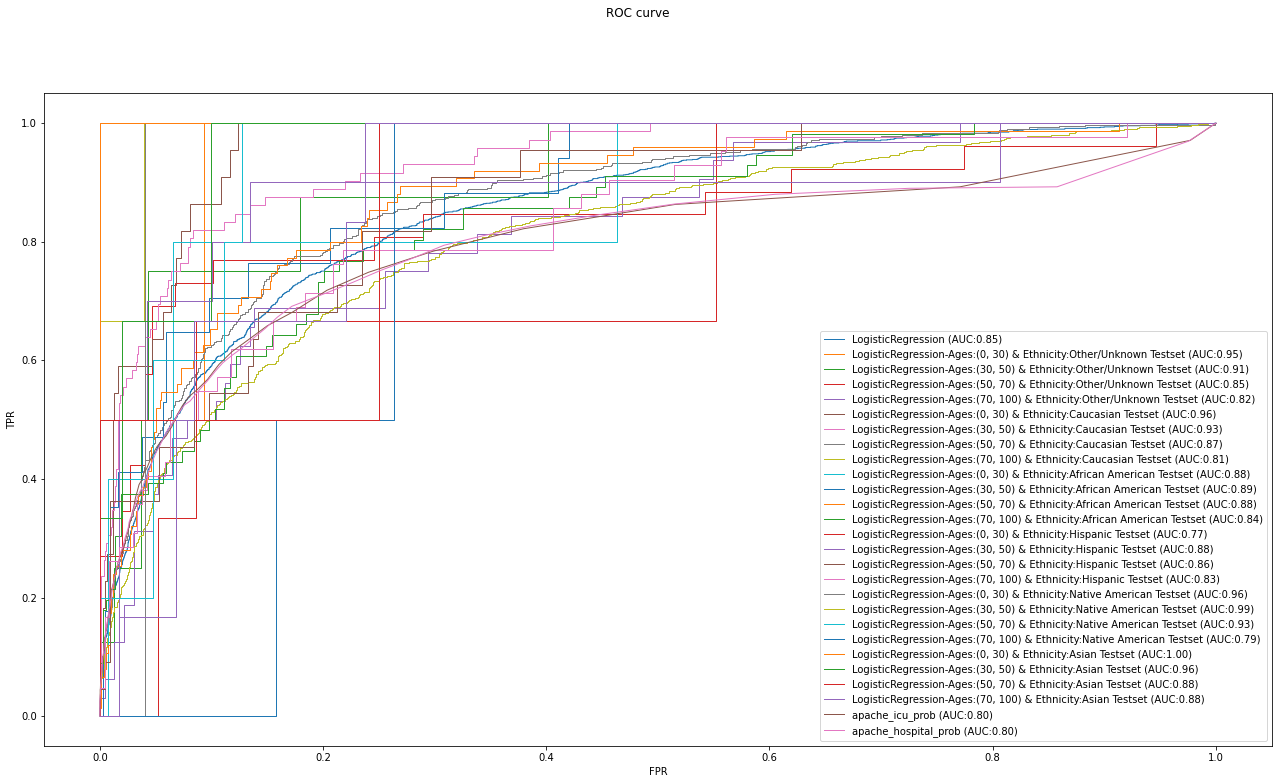

In [ ]:
plot_multiple_tests_roc_graphs(r_model, names, xs_test, ys_test, apache_icu_prob, apache_hospital_prob)

## Gender & Ethnicity Evaluation

In [ ]:
genders = list(X_train['gender'].unique())[:-1]
genders

['F', 'M']

In [ ]:
xs_test, ys_test, names = [X_test_fold_onehot], [y_test], ['LogisticRegression']
for ethnicity in ethnicities:
  ethnicity_test_df = test_df.query(f'ethnicity=="{ethnicity}"')
  for gender in genders:
    cur_test_df = ethnicity_test_df.query(f'gender=="{gender}"')
    X_test_cur, y_test_cur = cur_test_df[x_cols], cur_test_df[s_target]
    X_train_fold_onehot, X_test_cur_onehot = pre_processing_data(X_train, y_train, X_test_cur)
    model_name = f'LogisticRegression-Gender:{gender} & Ethnicity:{ethnicity} Testset'

    xs_test.append(X_test_cur_onehot)
    ys_test.append(y_test_cur)
    names.append(model_name)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)


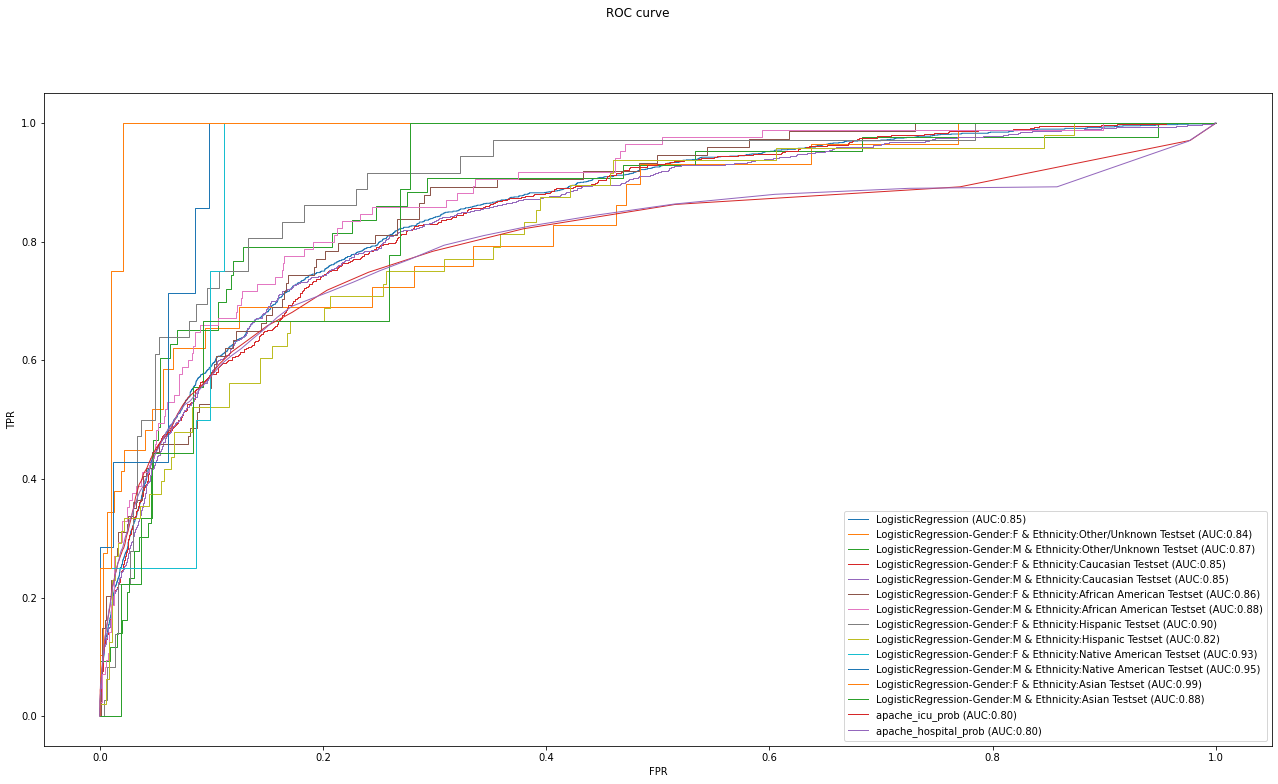

In [ ]:
plot_multiple_tests_roc_graphs(r_model, names, xs_test, ys_test, apache_icu_prob, apache_hospital_prob)

## Gender & Age Groups Evaluation

In [ ]:
xs_test, ys_test, names = [X_test_fold_onehot], [y_test], ['LogisticRegression']
for age_group in age_groups:
  ethnicity_test_df = test_df.query(f'age >= {age_group[0]} & age < {age_group[1]}')
  for gender in genders:
    cur_test_df = ethnicity_test_df.query(f'gender=="{gender}"')
    X_test_cur, y_test_cur = cur_test_df[x_cols], cur_test_df[s_target]
    X_train_fold_onehot, X_test_cur_onehot = pre_processing_data(X_train, y_train, X_test_cur)
    model_name = f'LogisticRegression-Ages:{age_group} & Gender:{gender} Testset'

    xs_test.append(X_test_cur_onehot)
    ys_test.append(y_test_cur)
    names.append(model_name)

Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of features after filitering: 98
pre prcoessing fucntion
train shape (before feature selection): (73370, 531)
train shape (after feature selection): (73370, 57)
Number of features before filitering: 180
Number of feat

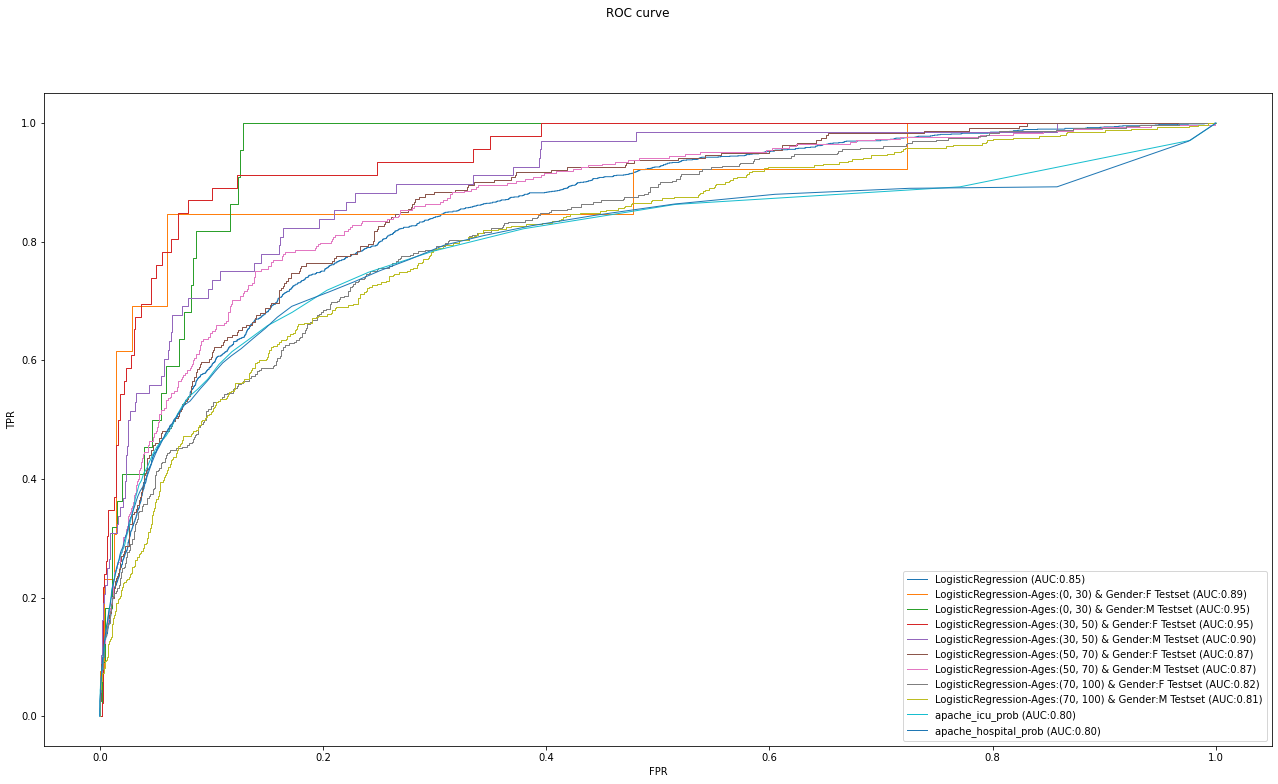

In [ ]:
plot_multiple_tests_roc_graphs(r_model, names, xs_test, ys_test, apache_icu_prob, apache_hospital_prob)

## Ethnicity & Gender & Age Groups Evaluation

In [ ]:
xs_test, ys_test, names = [X_test_fold_onehot], [y_test], ['LogisticRegression']

for ethnicity in ethnicities:
  ethnicity_test_df = test_df.query(f'ethnicity=="{ethnicity}"')
  for age_group in age_groups:
    age_test_df = ethnicity_test_df.query(f'age >= {age_group[0]} & age < {age_group[1]}')
    for gender in genders:
      try:
        cur_test_df = age_test_df.query(f'gender=="{gender}"')
        X_test_cur, y_test_cur = cur_test_df[x_cols], cur_test_df[s_target]
        X_train_fold_onehot, X_test_cur_onehot = pre_processing_data(X_train, y_train, X_test_cur)
        model_name = f'LogisticRegression-Ages:{age_group} & Ethnicity:{ethnicity} & Gender:{gender} Testset'

        xs_test.append(X_test_cur_onehot)
        ys_test.append(y_test_cur)
        names.append(model_name)
      except:
        print('*'*30, 'Error', '*'*30)
        print(f'LogisticRegression-Ages:{age_group} & Ethnicity:{ethnicity} & Gender:{gender} Testset')
        continue

Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98
Number of features before filitering: 180
Number of features after filitering: 98
Number of features before filitering: 180
Number of features after filitering: 98
Number of features before filitering: 180
Number of features after filitering: 98
Number of features before filitering: 180
Number of features after filitering: 98
Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Number of features before filitering: 180
Number of features after filitering: 98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
plt.clf()

<Figure size 432x288 with 0 Axes>

LogisticRegression-Ages:(0, 30) & Ethnicity:Native American & Gender:F Testset
LogisticRegression-Ages:(0, 30) & Ethnicity:Asian & Gender:M Testset


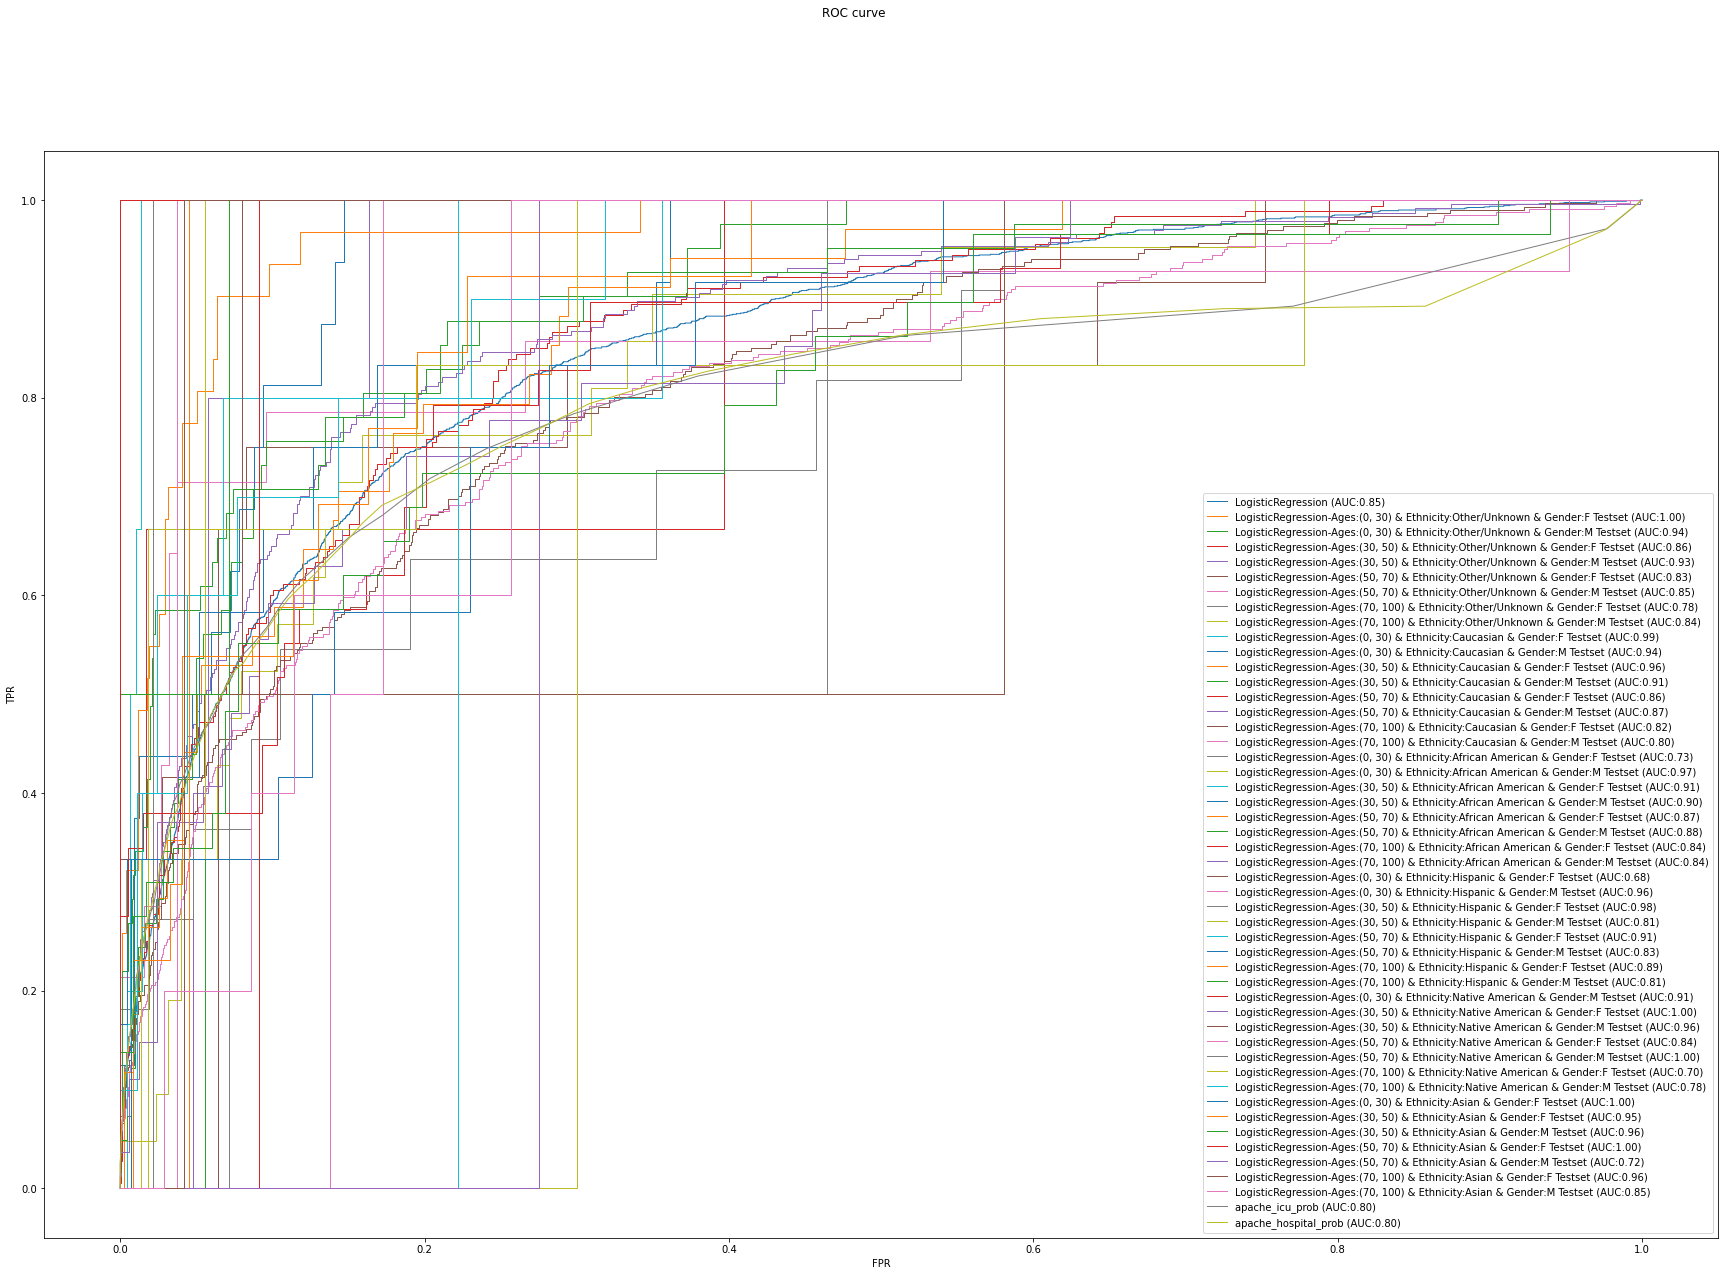

In [ ]:
plot_multiple_tests_roc_graphs(r_model, names, xs_test, ys_test, apache_icu_prob, apache_hospital_prob)